In [94]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load Iris Dataset

In [95]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
df["y"] = iris["target"]
df["y"] = df["y"].map(dict(enumerate(iris.target_names)))

# Keep only rows where y is `Virginica` or `Versicolor`
df = df[df["y"].isin(["virginica", "versicolor"])]

# Keep only `sepal length (cm)` and `sepal width (cm)` columns

columns_to_keep = ["sepal length (cm)", "sepal width (cm)"]
df = df.loc[:, columns_to_keep + ["y"]]

In [96]:
print(f"Number of instances: {len(df)}")

Number of instances: 100


## Split Train/Test

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("y", axis=1), df["y"], test_size=0.3, random_state=42, stratify=df["y"]
)

## Preprocessing (Scaling)

Este paso realmente no es estrictamente necesario dado que las features que componen el conjunto de datos están en la misma escala (cm)

In [98]:
# Define the columns to be transformed
continuous_columns = X_train.select_dtypes(include=["float64"]).columns

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
    ]
)

# Aplicar las transformaciones
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train_virginica = X_train[y_train == "virginica"]
X_train_versicolor = X_train[y_train == "versicolor"]

X_train = pd.DataFrame(X_train, columns=continuous_columns)
X_test = pd.DataFrame(X_test, columns=continuous_columns)

---

## LDA/QDA Training

In [99]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

In [100]:
def plot_confusion_matrix(
    y_true: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=iris.target_names[1:]
    )
    disp.plot(cmap="Blues")
    plt.grid(False)
    plt.gca().set_frame_on(False)
    plt.show()


def display_decision_boundary(
    model: sklearn.base.BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    xlabel: str,
    ylabel: str,
    ax=None,
):
    """Display the decision boundary of a model.

    Parameters
    ----------
    model : sklearn.base.BaseEstimator
        Model to display the decision boundary of.
    X : pd.DataFrame
        Dataframe containing the features.
    y : pd.Series
        Series containing the target.
    xlabel : str
        Feature to display on the x-axis.
    ylabel : str
        Feature to display on the y-axis.
    ax : matplotlib.axes, optional
        The axes on which to plot. If None, a new figure will be created.
    """
    # Use provided ax or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the decision boundary
    disp = DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
        xlabel=xlabel,
        ylabel=ylabel,
        alpha=0.5,
        ax=ax,
    )

    # Add scatterplot
    sns.scatterplot(
        data=X,
        x=xlabel,
        y=ylabel,
        hue=y_test.reset_index(drop=True),  # Reset index to avoid misalignment
        alpha=0.5,
        ax=ax,
    )

    return disp


In [101]:
# This dictionary is needed to build a comparative DataFrame between models
models_accuracy_dict = {
    "Model": ["LDA", "QDA"],
    "Accuracy": [],
}

### LDA

In [102]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)

              precision    recall  f1-score   support

  versicolor       0.65      0.87      0.74        15
   virginica       0.80      0.53      0.64        15

    accuracy                           0.70        30
   macro avg       0.73      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30



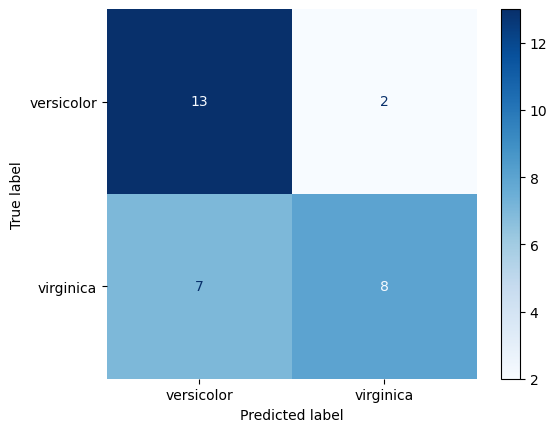

In [103]:
print(classification_report(y_test, y_pred_lda))
plot_confusion_matrix(y_test, y_pred_lda)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_lda))

---

### QDA

In [104]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)

y_pred_qda = qda.predict(X_test)

              precision    recall  f1-score   support

  versicolor       0.63      0.80      0.71        15
   virginica       0.73      0.53      0.62        15

    accuracy                           0.67        30
   macro avg       0.68      0.67      0.66        30
weighted avg       0.68      0.67      0.66        30



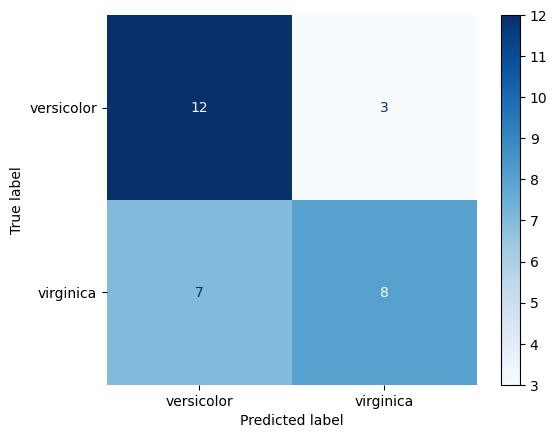

In [105]:
print(classification_report(y_test, y_pred_qda))
plot_confusion_matrix(y_test, y_pred_qda)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_qda))

---

## Model Accuracy Comparision

In [106]:
pd.DataFrame(models_accuracy_dict)

,Model,Accuracy
0,LDA,0.700000
1,QDA,0.666667


Cualquiera de las tres variaciones de **RDA** obtuvieron el mismo Accuracy. **RDA** ofrece un 4% más de Accuracy que **LDA** y un 9.5% más que **QDA**. **QDA** es el método con menor Accuracy

## Display the Decision Boundary

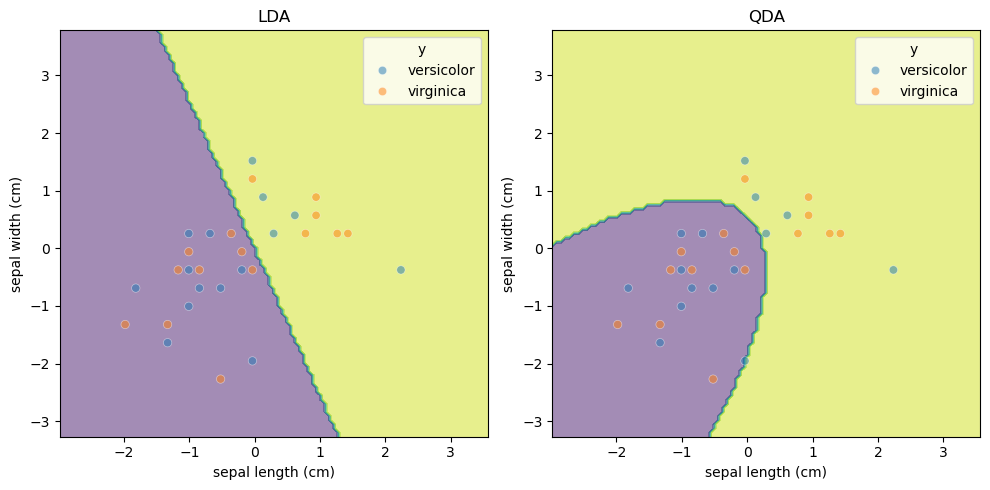

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

# Plot each model in a different subplot
models = {
    "LDA": lda,
    "QDA": qda,
}

for i, (name, model) in enumerate(models.items()):
    display_decision_boundary(
        model,
        X_train,
        y_train,
        "sepal length (cm)",
        "sepal width (cm)",
        ax=axes[i],
    )
    axes[i].set_title(f"{name}")

# Remove unused subplot if necessary
if len(models) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Kernel Density Estimation (KDE)

In [108]:
from sklearn.neighbors import KernelDensity

In [109]:
kde_parameters = {
    "bandwidth": [0.2, 0.5, 0.8],
    "kernel": ["gaussian", "tophat"],
}

In [110]:
kde_virginica = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(X_train_virginica)
kde_versicolor = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(X_train_versicolor)

In [111]:
# Define grid boundaries from the range of your data
x_min, x_max = (
    X_train["sepal length (cm)"].min() - 1,
    X_train["sepal length (cm)"].max() + 1,
)
y_min, y_max = (
    X_train["sepal width (cm)"].min() - 1,
    X_train["sepal width (cm)"].max() + 1,
)

# Create a grid with 100 points in each dimension
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Reshape the grid for KDE scoring
grid = np.c_[xx.ravel(), yy.ravel()]

# Now you can score samples on this grid
log_dens_virginica = kde_virginica.score_samples(grid)
log_dens_versicolor = kde_versicolor.score_samples(grid)
p_x_virginica = np.exp(log_dens_virginica)
p_x_versicolor = np.exp(log_dens_versicolor)

p_virginica = len(X_train_virginica) / len(X_train)
p_versicolor = len(X_train_versicolor) / len(X_train)

### Densidad Estimada

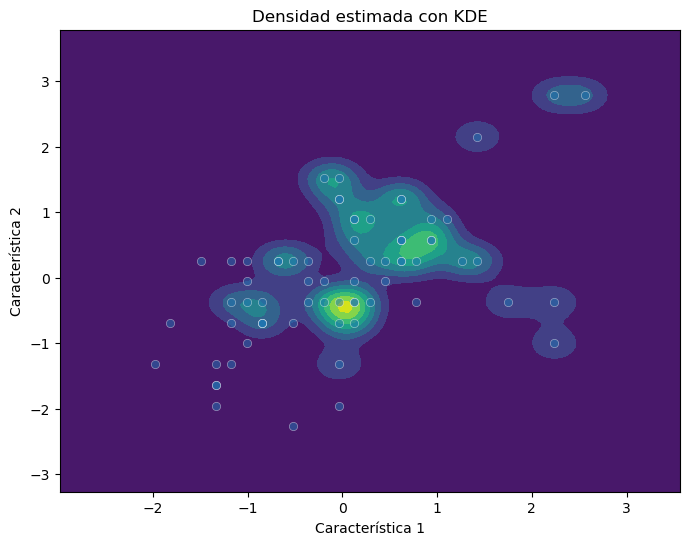

In [112]:
densidad_grid = p_x_virginica.reshape(xx.shape)

# Visualización de la densidad
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, densidad_grid, cmap="viridis")
sns.scatterplot(X_train, x="sepal length (cm)", y="sepal width (cm)", alpha=0.5)
plt.title("Densidad estimada con KDE")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

### Frontera de decisión

In [113]:
X_train_virginica = X_train[y_train.reset_index(drop=True) == "virginica"]
X_train_versicolor = X_train[y_train.reset_index(drop=True) == "versicolor"]

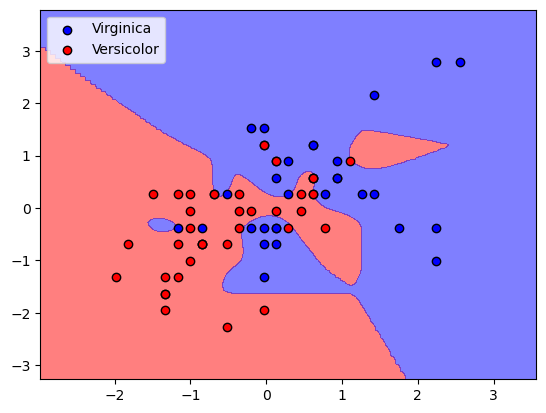

In [114]:
# Calculate discriminant functions
g_virginica = p_x_virginica * p_virginica
g_versicolor = p_x_versicolor * p_versicolor

# Difference of discriminant functions (the boundary is where this difference is zero)
diff = (g_virginica - g_versicolor).reshape(xx.shape)

plt.figure()
# We use `contourf` to color the regions according to the assigned class
plt.contourf(
    xx, yy, diff, levels=[-np.inf, 0, np.inf], alpha=0.5, colors=["red", "blue"]
)
plt.scatter(
    X_train_virginica.iloc[:, 0],
    X_train_virginica.iloc[:, 1],
    c="blue",
    edgecolor="k",
    label="Virginica",
)
plt.scatter(
    X_train_versicolor.iloc[:, 0],
    X_train_versicolor.iloc[:, 1],
    c="red",
    edgecolor="k",
    label="Versicolor",
)
# plt.title(f"Bandwidth: {bandwidth}, Kernel: {kernel}")
plt.legend()
plt.show()

/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


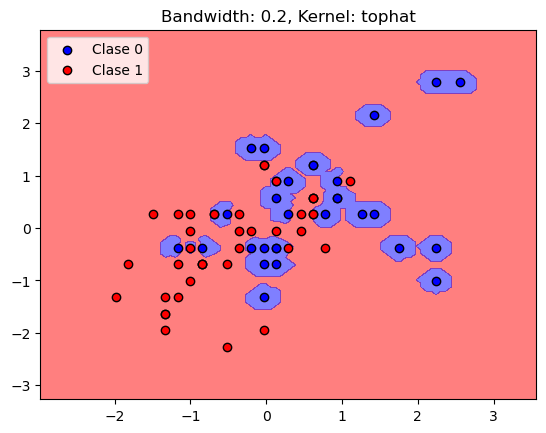

/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


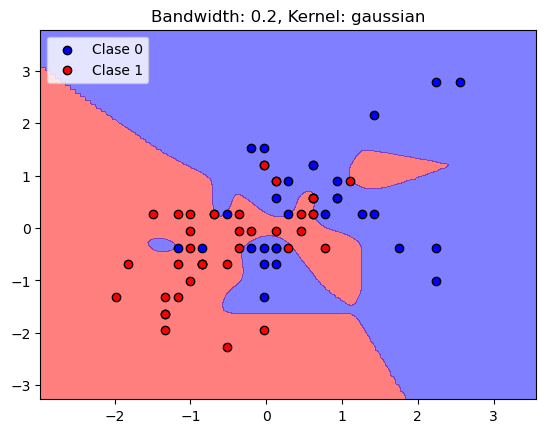

/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


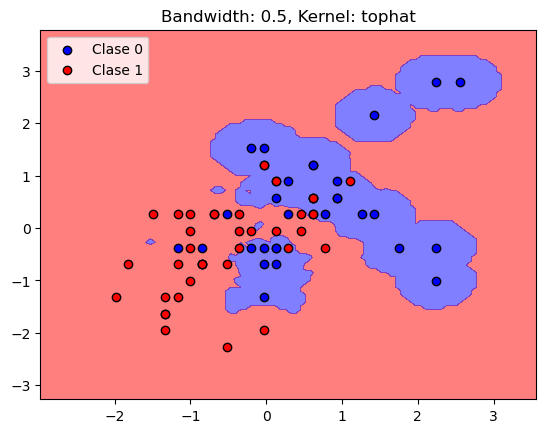

/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


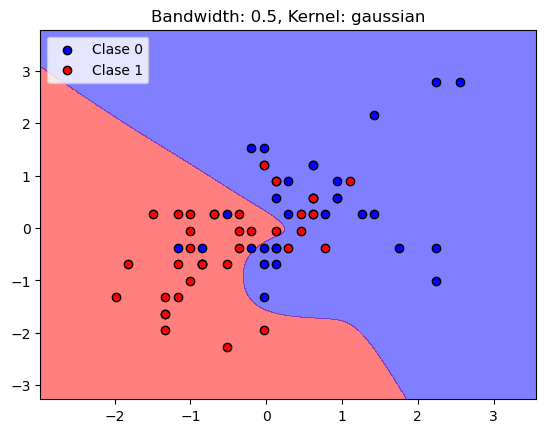

/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


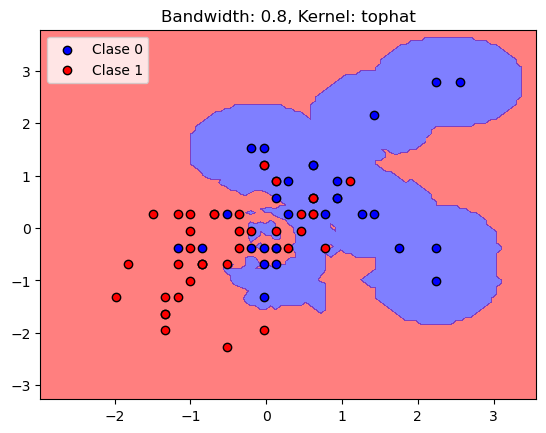

/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/DataMining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


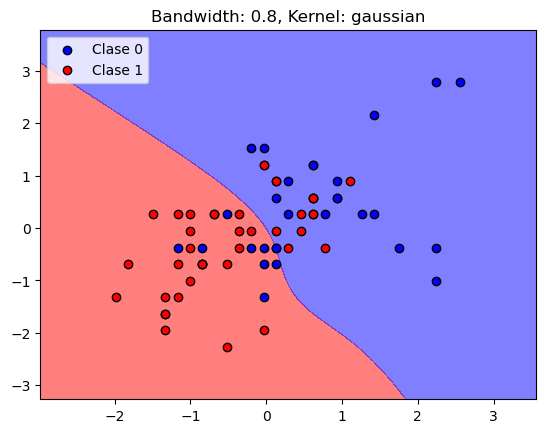

In [118]:
x_min, x_max = (
    X_train["sepal length (cm)"].min() - 1,
    X_train["sepal length (cm)"].max() + 1,
)
y_min, y_max = (
    X_train["sepal width (cm)"].min() - 1,
    X_train["sepal width (cm)"].max() + 1,
)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Parámetros a explorar
bandwidth_values = [0.2, 0.5, 0.8]
kernels = ["tophat", "gaussian"]

for bandwidth in bandwidth_values:
    for kernel in kernels:
        # Entrenar KDE para cada clase
        kde_c0 = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(
            X_train_virginica
        )
        kde_c1 = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(
            X_train_versicolor
        )

        # Evaluar la densidad en el grid
        log_dens0 = kde_c0.score_samples(grid)
        log_dens1 = kde_c1.score_samples(grid)

        p_x_c0 = np.exp(log_dens0)
        p_x_c1 = np.exp(log_dens1)

        # Calcular probabilidades a priori
        P_c0 = len(X_train_virginica) / len(X_train)
        P_c1 = len(X_train_versicolor) / len(X_train)

        # Calcular funciones discriminantes
        g0 = p_x_c0 * P_c0
        g1 = p_x_c1 * P_c1

        # Diferencia de funciones discriminantes (la frontera es donde esta diferencia es cero)
        diff = (g0 - g1).reshape(xx.shape)

        # Graficar la frontera de decisión y los datos
        plt.figure()
        # Usamos contourf para colorear las regiones según la clase asignada
        plt.contourf(
            xx, yy, diff, levels=[-np.inf, 0, np.inf], alpha=0.5, colors=["red", "blue"]
        )
        plt.scatter(
            X_train_virginica.iloc[:, 0],
            X_train_virginica.iloc[:, 1],
            c="blue",
            edgecolor="k",
            label="Clase 0",
        )
        plt.scatter(
            X_train_versicolor.iloc[:, 0],
            X_train_versicolor.iloc[:, 1],
            c="red",
            edgecolor="k",
            label="Clase 1",
        )
        plt.title(f"Bandwidth: {bandwidth}, Kernel: {kernel}")
        plt.legend()
        plt.show()

Al cambiar el parámetro de `bandwidth`, se pueden observar las siguientes consecuencias

**Para bandwith bajos:**
- La densidad estimada tiene picos muy pronunciados en torno a cada muestra.
- La frontera de decisión es irregular, rodeando grupos de puntos.
- La frontera de decisión muestra un sobreajuste, ya que se adapta a cada pequeña variación de los datos, incluso ruido.

**Para bandwith medios:**
- La densidad estimada reduce el numero de picos pronunciados en torno a cada muestra. La frontera de decisión abarca más instancias.
- La frontera de decisión se suaviza.

**Para bandwith altos:**
- Cada muestra extiende su influencia muy lejos; las "cajas" pasan a solaparse.
- La densidad global no tiene en cuenta detalles finos
- La frontera de decisión se observa muy suave

## k-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k_list = [1, 3, 5, 7, 9, 11]
knn_models = {}
for k in k_list:
    # Train a KNN classifier with the current value of k
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train, y_train)

    knn_models[k] = knn

    y_pred = knn.predict(X_test)

    print(f"Accuracy {k}-NN: {accuracy_score(y_test, y_pred)}")

Accuracy 1-NN: 0.6333333333333333
Accuracy 3-NN: 0.6333333333333333
Accuracy 5-NN: 0.5666666666666667
Accuracy 7-NN: 0.6666666666666666
Accuracy 9-NN: 0.5666666666666667
Accuracy 11-NN: 0.6


### Metricas para 3-NN

              precision    recall  f1-score   support

  versicolor       0.62      0.67      0.65        15
   virginica       0.64      0.60      0.62        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30



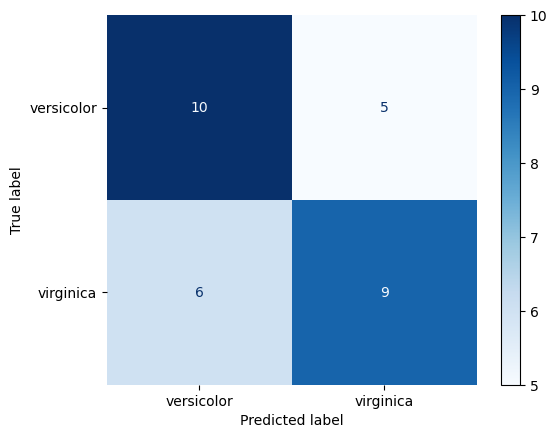

In [ ]:
y_pred_5nn = knn_models[3].predict(X_test)
print(classification_report(y_test, y_pred_5nn))
plot_confusion_matrix(y_test, y_pred_5nn)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_5nn))

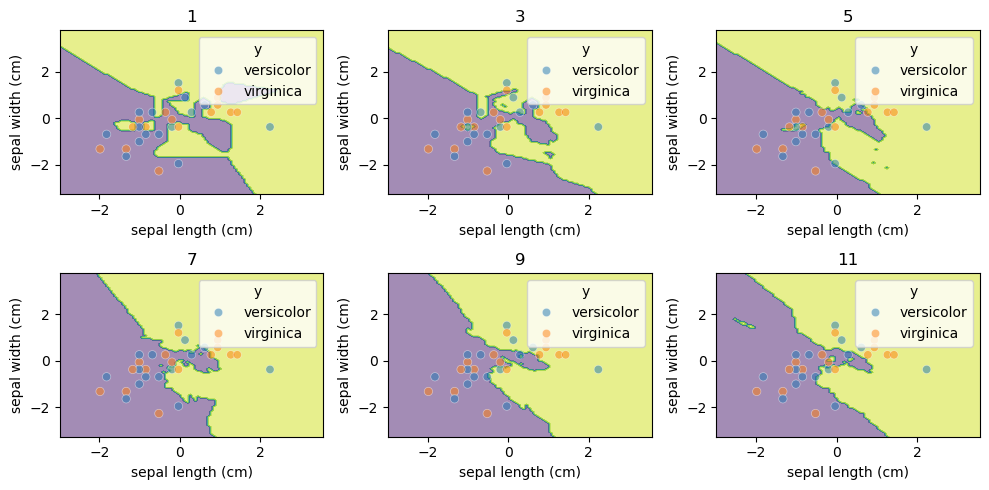

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.flatten()

for i, (k, model) in enumerate(knn_models.items()):
    display_decision_boundary(
        model,
        X_train,
        y_train,
        "sepal length (cm)",
        "sepal width (cm)",
        ax=axes[i],
    )
    axes[i].set_title(f"{k}")

# Remove unused subplot if necessary
if len(knn_models) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Al aumentar el número de vecinos `k`, la frontera de decisión tiende a suavizarse.

Al cambiar este parámetro, se pueden observar las siguientes consecuencias

**Para `k` bajos (1 a 3):**
- Alto sorbreajuste. El modelo memoriza excesivamente la localización exacta de cada muestra y adapta la frontera a cada mínimo grupo de vecinos.
- Se tiene en cuenta unicamente lo más cercano a la instancia a clasificar, y este grupo de puntos pueden no ser representativos (atipicos)

**Para `k` medios (5 a 7):**
- La frontera deja de tener en cuenta el ruido.
- La frontera de decisión es más suave y las regiones aisladas tienden a solaparse

**Para `k` altos (9 a 11):**
- A medida que `k ` aumenta, k se acerca más a N, por lo tanto, casi todos los puntos reciben el mismo voto de vecinos: la clasificación tiende a la clase mayoritaria global.

### Diferencia de Frontera de Decisión entre Métodos Paramétricos y No Paramétricos

A simple vista se puede observar que los métodos paramétricos (LDA y QDA) tienen fronteras de decisión menos irregulares, siendo la frontera de decisión de LDA lineal y la de QDA una curva. Estos métodos, al asumir una serie de parámetros sobre los datos, ofrecen una frontera de decisión menos afectada por el sobreajuste; este sobreajuste es observable en los métodos no paramétricos (KDE y k-NN), los cuales dependen de una buena selección de los parámetros `h` y `k`. 

El problema del uso de los métodos paramétricos, es cuando se utilizan en situaciones donde no se cumplen los supuestos en los que se apoyan. Esto produciría modelos con muy baja calidad predictiva. 

Por otro lado, los métodos no paramétricos, poseen la flexibilidad de adaptarse a diferentes estructuras en los datos. De ahí viene la frase "dejar que los datos hablen". El único inconveniente al que se entfrentan, es que por esa característica versastil, es necesario poner atención y ser cauteloso con la elección de los parámetros del modelo en particular, tratando de encontrar un equilibrio óptimo entre sesgo y varianza.